## Business Understanding

Zillow’s Zestimate home valuation has shaken up the U.S. real estate industry since first released 11 years ago.

A home is often the largest and most expensive purchase a person makes in his or her lifetime. Ensuring homeowners have a trusted way to monitor this asset is incredibly important. The Zestimate was created to give consumers as much information as possible about homes and the housing market, marking the first time consumers had access to this type of home value information at no cost.

“Zestimates” are estimated home values based on 7.5 million statistical and machine learning models that analyze hundreds of data points on each property. And, by continually improving the median margin of error (from 14% at the onset to 5% today), Zillow has since become established as one of the largest, most trusted marketplaces for real estate information in the U.S. and a leading example of impactful machine learning.

#### Objective:

Our task in this competition is to predict the the difference between the actual price and the estimate of the price (Zestimate). So, in fact we are predicting, where Zillow’s Zestimate will be good, and where it will be bad.


The dataset consists of information about 2.9 million properties and is grouped into 2 files:

properties_2016.csv (containing information about the properties themselves)
train_2016.csv (containing information about the transcations before october 15,2016)

In [47]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix,accuracy_score
import re
from ggplot import *
color = sns.color_palette()
import datetime
from catboost import CatBoostRegressor
from category_encoders import BinaryEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelBinarizer,Imputer,OneHotEncoder,LabelEncoder
#from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import dump_svmlight_file

from sklearn.cross_validation import train_test_split


%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

#### Reading the dataset

In [2]:
train=pd.read_csv('C:/Users/Lenovo/Downloads/all/train_2016_v2.csv',parse_dates=['transactiondate'])
properties=pd.read_csv('C:/Users/Lenovo/Downloads/all/properties_2016.csv')
sample=pd.read_csv('C:/Users/Lenovo/Downloads/all/sample_submission.csv')

C:\Users\Lenovo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
for c, dtype in zip(properties.columns, properties.dtypes):
    if dtype == np.float64:
        properties[c] = properties[c].astype(np.float32)
        

#### Statistical Summary

### Data wrangling:


Lets first analyze the missingness in the data

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


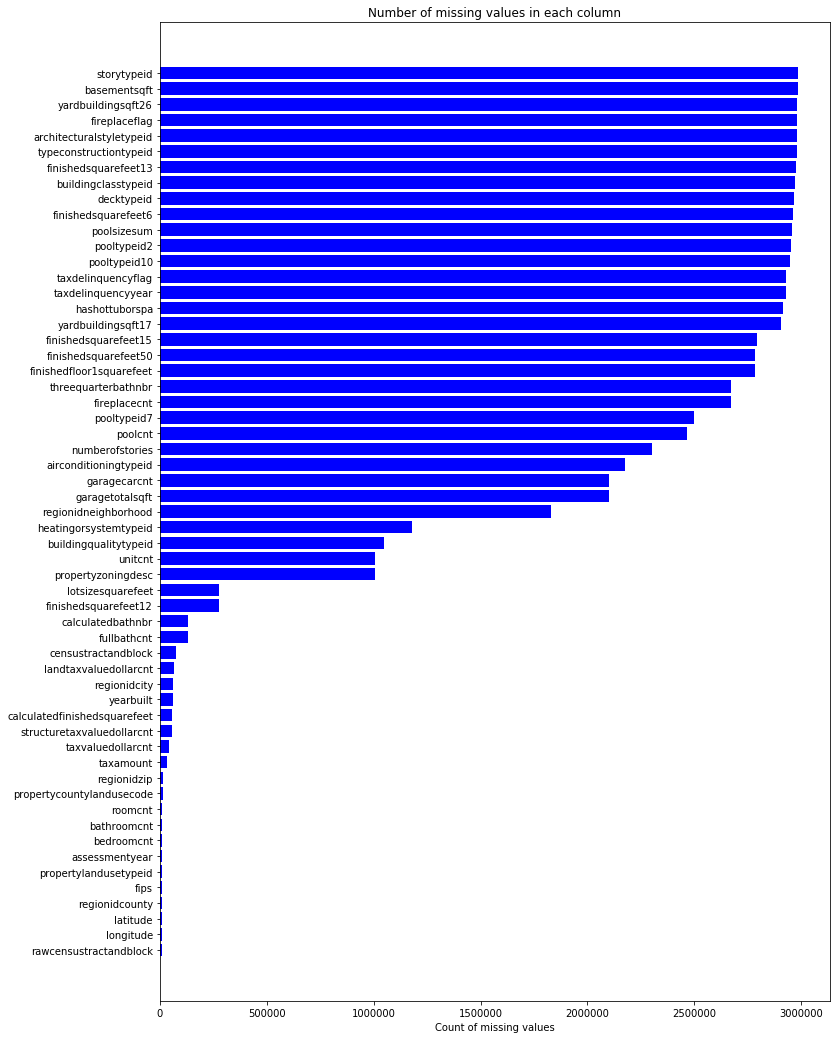

In [4]:
missing_df = properties.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()


The above plot shows degree of missingness. several features have missingness more than 90%. So multiple imputation strategies has to be employed for accuracy and contingency of the Machine Learning models.

Missing data was imputation by analyzing each variable individually by looking at its missingness, type and common sense. The imputation strategies are shown below:

1. Variables with missingness greater than 95% were discarded.
2. By inspecting the correlation plot, I found some variables are highly correlated to each other. For correlated variables, I only kept the one with the least missingness and discarded the others.
3. For categorical variables variables with values either ‘True’ or NANs, convertin them to numeric using dummy variable.
4. For others I have  imputed with the median value.
5. Outlier detection and removal from logerror and few other impotant features.
6. droping all the features with only one unique value

In [5]:
#'bathroomcnt', 'calculatedbathnbr' have same description
properties['bathroomcnt'].isnull().sum() #----25

properties['calculatedbathnbr'].isnull().sum() #----117475

#we will drop 'calculatedbathnbr' as it has more null values
drop_cols=['calculatedbathnbr']


#'finishedfloor1squarefeet', 'finishedsquarefeet50' have same description
properties['finishedfloor1squarefeet'].isnull().sum() #

properties['finishedsquarefeet50'].isnull().sum() #

#we will drop 'finishedsquarefeet50' as it has more null values
drop_cols.append('finishedsquarefeet50')



In [6]:
#FIPS:Federal Information Processing Standard code. This column is mostly redundant. So we are droping this column
properties.fips.unique()
drop_cols.append('fips')

#columns rawcensustractandblock and censustractandblock contain same information. lets retain rawcensustractandblock since it has no NaN values.
properties.rawcensustractandblock.isnull().sum()#----0

properties.censustractandblock.isnull().sum()#-----63689
drop_cols.append('censustractandblock')


In [7]:
#updating 'pooltypeid10'=1 when 'pooltypeid2'=1(Pool with Spa/Hot Tub)
properties['pooltypeid10']=np.where(properties['pooltypeid2']==1,1,0) 

#updating NaN values to 0
properties['pooltypeid7']=np.where(properties['pooltypeid7'].isnull(),0,1)

#updating NaN values to 0 
properties['pooltypeid2']=np.where(properties['pooltypeid2'].isnull(),0,1)


#updating 'poolcnt'=1 when 'pooltypeid2'=1
properties['poolcnt']=np.where(properties['pooltypeid2']==1,1,0) 

#updating 'poolcnt'=1 when 'pooltypeid7'=1 ((Pool without Spa/Hot Tub))
properties['poolcnt']=np.where(properties['pooltypeid7']==1,1,0) 


#If there is no pool pool size must be zero
properties['poolsizesum']=np.where(properties['poolcnt'].isnull(),0,1)

In [8]:
#updating airconditioningtypeid to 6, which is 'other' category, refering zillow data dictionary
index = properties.airconditioningtypeid.isnull()
properties.loc[index,'airconditioningtypeid'] = 6

#The below variables are flags and lets assume if they are NA's it means the object does not exist so lets fix this
index = properties.hashottuborspa.isnull()
properties.loc[index,'hashottuborspa'] = "None"

#updating heatingorsystemtypeid to 14, which is 'other' category, refering zillow data dictionary
index = properties.heatingorsystemtypeid.isnull()
properties.loc[index,'heatingorsystemtypeid'] = 14


#updating taxdelinquencyflag to valid flag based on the value of taxdelinquencyyear
properties['taxdelinquencyflag']=np.where(properties['taxdelinquencyyear'].isnull(),'None','True')

#updating taxdelinquencyflag to valid flag based on the value of taxdelinquencyyear
index = properties.fireplacecnt.isnull()
properties.loc[index,'fireplacecnt'] = 0

properties['fireplaceflag']=np.where(properties['fireplacecnt']==0,'None','True')

#properties['regionidzip'].isnull().sum()
#drop_cols.append('regionidzip')

In [9]:

#if 'bathroomcnt'=0 then 'fullbathcnt' and 'threequarterbathnbr' should be zero too

index = properties.bathroomcnt.isnull()
properties.loc[index,'fullbathcnt'] = 0
properties.loc[index,'threequarterbathnbr'] = 0

index = properties.roomcnt.isnull()
properties.loc[index,'roomcnt']=properties['roomcnt'].median()

index = properties.numberofstories.isnull()
properties.loc[index,'numberofstories'] = 0


### Feature Engineering

Derived a new feature "Age_of_home" based on yearbuilt.

In [10]:
properties['Age_of_Home']=2018-properties['yearbuilt']


In [11]:
properties.drop(columns=drop_cols,inplace=True)
properties.fillna(properties.median(), inplace=True)

In [12]:
train_merge = train.merge(properties, how='left', on='parcelid')


In [13]:
### Adding some new features from transactiondate
train_merge['month'] = train_merge['transactiondate'].dt.month
train_merge['day_of_week'] = train_merge['transactiondate'].dt.weekday_name
train_merge['week_number'] = train_merge['transactiondate'].dt.week

In [14]:
train_merge.describe()

,parcelid,logerror,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet6,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,Age_of_Home,month,week_number
count,9.027500e+04,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.0,90275.000000,90275.0,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,9.027500e+04,9.027500e+04,9.027500e+04,90275.000000,90275.0,90275.000000,90275.000000,90275.000000,90275.000000,9.027500e+04,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.0,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,9.027500e+04,9.027500e+04,90275.000000,9.027500e+04,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000
mean,1.298466e+07,0.011457,4.666198,7.000665,534.693176,2.279474,3.031869,4.0,6.088408,66.0,1287.155518,1771.716431,1734.689575,1296.039673,2182.714844,1991.431885,0.126414,2.238073,1.937657,409.004944,7.742509,3.400397e+07,-1.182102e+08,2.662503e+04,0.184957,1.0,0.013337,0.013337,0.184957,261.718475,6.047366e+07,33595.238281,2526.343262,147486.109375,96577.125000,1.478516,7.0,1.001163,6.000033,1.071371,271.176666,168.151215,1968.365601,0.328286,1.798490e+05,4.576762e+05,2015.907715,2.783347e+05,5983.834473,13.988203,49.513466,5.849848,23.525295
std,2.504510e+06,0.161079,2.572695,0.146290,10.232337,1.004230,1.156281,0.0,1.664423,0.0,180.568619,924.908569,887.208069,2.932873,215.939423,94.252953,0.398743,0.957204,0.361580,160.201584,5.684542,2.649672e+05,3.607793e+05,1.148876e+05,0.388265,0.0,0.114714,0.114714,0.388265,5.183539,2.058606e+05,46222.488281,805.971497,110686.328125,3660.502441,2.819749,0.0,0.036882,0.025128,0.643227,37.696785,12.107722,23.669233,0.657902,2.087202e+05,5.548729e+05,0.907591,4.004897e+05,6838.583008,0.390498,23.668558,2.812690,12.260320
min,1.071174e+07,-4.605000,1.000000,2.000000,100.000000,0.000000,0.000000,4.0,1.000000,66.0,44.000000,2.000000,2.000000,1056.000000,560.000000,257.000000,0.000000,1.000000,0.000000,0.000000,1.000000,3.333930e+07,-1.194479e+08,1.670000e+02,0.000000,1.0,0.000000,0.000000,0.000000,31.000000,6.037101e+07,3491.000000,1286.000000,6952.000000,95982.000000,0.000000,7.0,1.000000,4.000000,1.000000,25.000000,18.000000,1885.000000,0.000000,1.000000e+02,2.200000e+01,2015.000000,2.200000e+01,49.080002,6.000000,3.000000,1.000000,1.000000
25%,1.155950e+07,-0.025300,1.000000,7.000000,534.000000,2.000000,2.000000,4.0,4.000000,66.0,1283.000000,1187.000000,1190.000000,1296.000000,2172.000000,1992.000000,0.000000,2.000000,2.000000,441.000000,2.000000,3.381154e+07,-1.184117e+08,5.962000e+03,0.000000,1.0,0.000000,0.000000,0.000000,261.000000,6.037320e+07,12447.000000,1286.000000,118920.000000,96193.000000,0.000000,7.0,1.000000,6.000000,1.000000,270.000000,168.000000,1953.000000,0.000000,8.149000e+04,1.990235e+05,2015.000000,8.222800e+04,2872.884888,14.000000,31.000000,4.000000,14.000000
50%,1.254734e+07,0.006000,6.000000,7.000000,534.000000,2.000000,3.000000,4.0,7.000000,66.0,1283.000000,1547.000000,1539.000000,1296.000000,2172.000000,1992.000000,0.000000,2.000000,2.000000,441.000000,7.000000,3.402150e+07,-1.181734e+08,7.000000e+03,0.000000,1.0,0.000000,0.000000,0.000000,261.000000,6.037620e+07,25218.0

Interesting facts from the above describe function:

1. Look at the bedroom columns , the dataset has a house where the house has 16 bedrooms , seems to be a massive house.
2. Dataset has a house with 20 bath rooms
3. Maximum square feet is 13,450 where as the minimum is 290. we can see that the data is distributed

In [15]:
#We will drop any coulmn with more than 95% missing values.

missing_perc_thresh = 0.95
exclude_missing = []
num_rows = train_merge.shape[0]
for c in train_merge.columns:
    num_missing = train_merge[c].isnull().sum()
    if num_missing == 0:
        continue
    missing_frac = num_missing / float(num_rows)
    if missing_frac > missing_perc_thresh:
        exclude_missing.append(c)
print("We exclude: %s" % exclude_missing)
print(len(exclude_missing))

We exclude: []
0


In [16]:
# exclude where we only have one unique value 
exclude_unique = []
for c in train_merge.columns:
    num_uniques = len(train_merge[c].unique())
    if train_merge[c].isnull().sum() != 0:
        num_uniques -= 1
    if num_uniques == 1:
        exclude_unique.append(c)
print("We exclude: %s" % exclude_unique)
print(len(exclude_unique))

We exclude: ['buildingclasstypeid', 'decktypeid', 'poolsizesum', 'storytypeid', 'assessmentyear']
5


In [17]:
#Selecting categorical variables for model building.
exclude_other = ['transactiondate','propertycountylandusecode','propertyzoningdesc','day_of_week']
cat_feature_inds = []
col=train_merge.columns
cat_unique_thresh = 1000
for c in train_merge.columns:
     if train_merge[c].dtype == 'object' \
            and c not in exclude_other:
        cat_feature_inds.append(c)       
print("Cat features are: %s" %  cat_feature_inds)

Cat features are: ['hashottuborspa', 'fireplaceflag', 'taxdelinquencyflag']


In [18]:
# displaying unique categorical variables and thier count
for name in cat_feature_inds:
    print("Unique Values in column: {}\n".format(name))
    print(train_merge[name].value_counts(),'\n')

Unique Values in column: hashottuborspa

None    87910
True     2365
Name: hashottuborspa, dtype: int64 

Unique Values in column: fireplaceflag

None    80668
True     9607
Name: fireplaceflag, dtype: int64 

Unique Values in column: taxdelinquencyflag

None    88492
True     1783
Name: taxdelinquencyflag, dtype: int64 



### Handling Categorical Variables

In [19]:
for c in cat_feature_inds:
    dummy=pd.get_dummies(train_merge[c],prefix=c)
    train_merge=pd.concat([train_merge,dummy],axis=1)
train_merge.drop(['hashottuborspa', 'fireplaceflag', 'taxdelinquencyflag'],axis=1,inplace=True)


### Feature selection

In [20]:
exclude_other = ['parcelid', 'logerror','regionidcounty','latitude', 'longitude','transactiondate','month','week_number'] 
train_features = []
for c in train_merge.columns:
    if c not in exclude_missing \
       and c not in exclude_other \
        and c not in exclude_unique and train_merge[c].dtype != 'object':
        train_features.append(c)
print("We use these for training: %s" % train_features)
print(len(train_features))


We use these for training: ['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet6', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'heatingorsystemtypeid', 'lotsizesquarefeet', 'poolcnt', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity', 'regionidneighborhood', 'regionidzip', 'roomcnt', 'threequarterbathnbr', 'typeconstructiontypeid', 'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt', 'numberofstories', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'taxdelinquencyyear', 'Age_of_Home', 'hashottuborspa_True', 'hashottuborspa_None', 'fireplaceflag_None', 'fireplaceflag_True', 'taxdelinquencyflag_None', 'taxdelinquencyflag_True']
47

#### Univariate Analysis:

Since there are so many variables, let us first take the 'float' variables alone and then get the correlation with the target variable to see how they are related.

C:\Users\Lenovo\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Lenovo\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


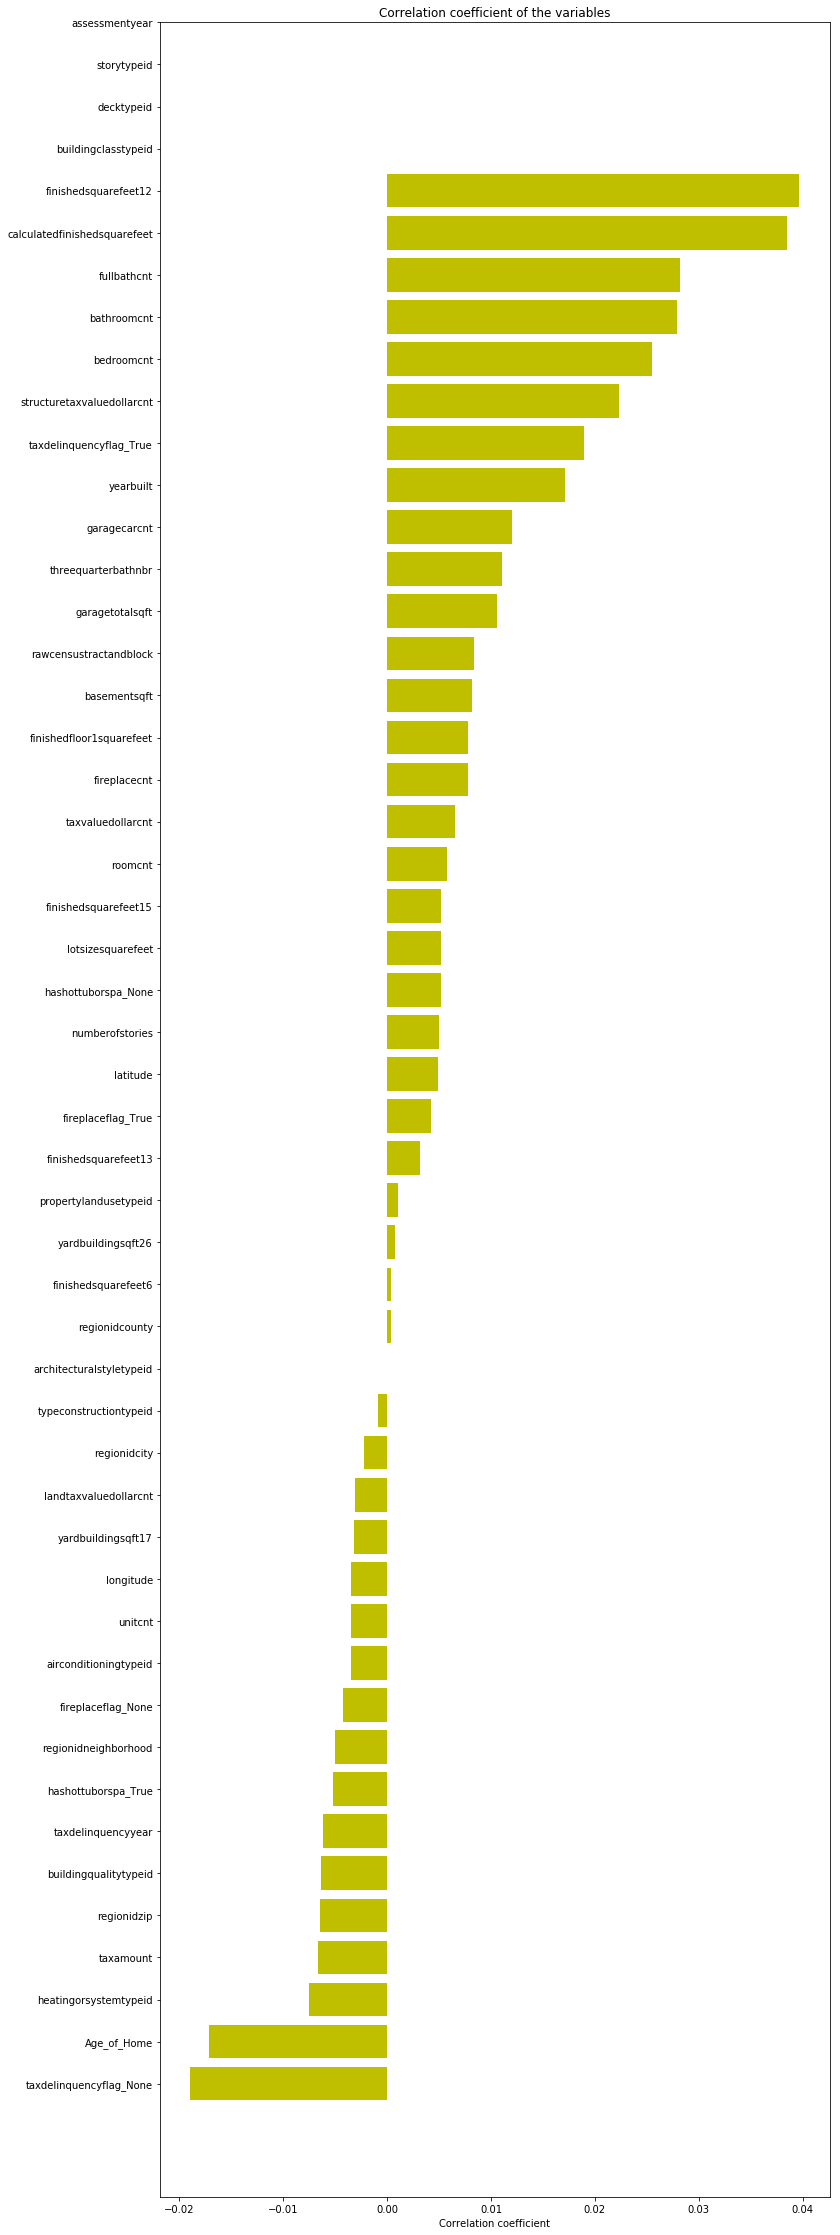

In [21]:
# Let us just impute the missing values with mean values to compute correlation coefficients #
#median_values = train_merge.median(axis=0)
#train_merge=pd.DataFrame(train_merge.fillna(median_values, inplace=True))
#train_merge.fillna(-999,inplace=True)
x_cols = [col for col in train_merge.columns if col not in ['logerror']  if train_merge[col].dtype=='float32' or train_merge[col].dtype=='uint8']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_merge[col].values, train_merge.logerror.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
#autolabel(rects)
plt.show()

In [22]:
imp_features=corr_df.ix[(corr_df['corr_values']>0.02) | (corr_df['corr_values'] < -0.01)]
imp_features

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,col_labels,corr_values
48,taxdelinquencyflag_None,-0.018936
43,Age_of_Home,-0.017137
37,structuretaxvaluedollarcnt,0.022328
4,bedroomcnt,0.025467
3,bathroomcnt,0.027889
15,fullbathcnt,0.028197
9,calculatedfinishedsquarefeet,0.038469
10,finishedsquarefeet12,0.039659


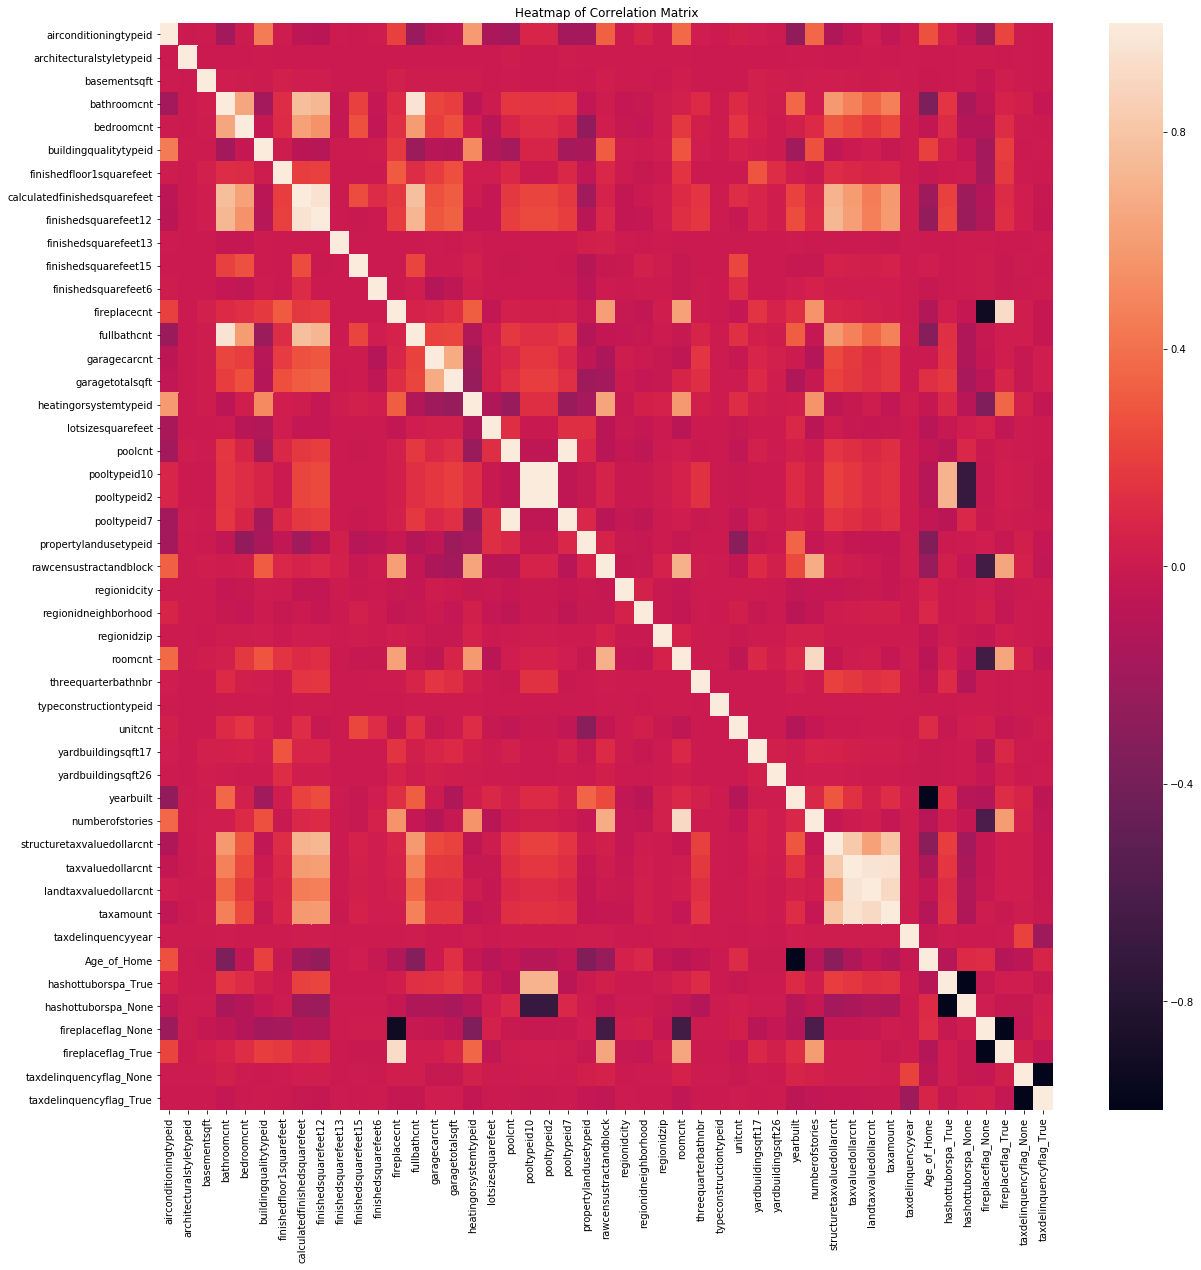

In [23]:
df=train_merge[train_features]
corr=df.corr()

width = 0.9
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr, xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
ax.set_title('Heatmap of Correlation Matrix')
plt.show()


From the heat map above, we can see high intercorrelation among independant variables. This is sign of multicollinearity in the data, which will affect the statistical inferences made about the data.

'logerror' is the target variable for our prediction. So lets analyze this.

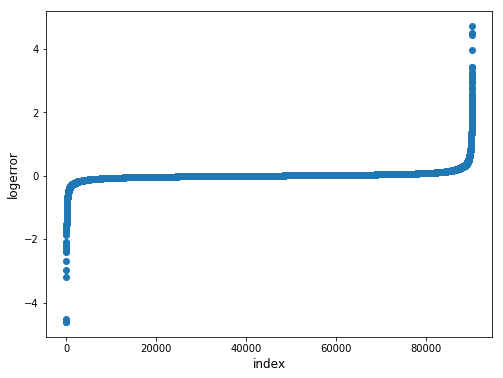

In [24]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_merge.shape[0]), np.sort(train_merge.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

Scatter plot for the dependent variable shows there are outliers in the data. Lets plot the histogram to visualize the distribution.

In [25]:
# Removing outliers
mean = np.mean(train_merge['logerror'], axis=0)
sd = np.std(train_merge['logerror'], axis=0)

llimit=mean - 3 * sd
ulimit=mean + 3 * sd

train_merge['logerror'].ix[train_merge['logerror']>ulimit] = ulimit
train_merge['logerror'].ix[train_merge['logerror']<llimit] = llimit




C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


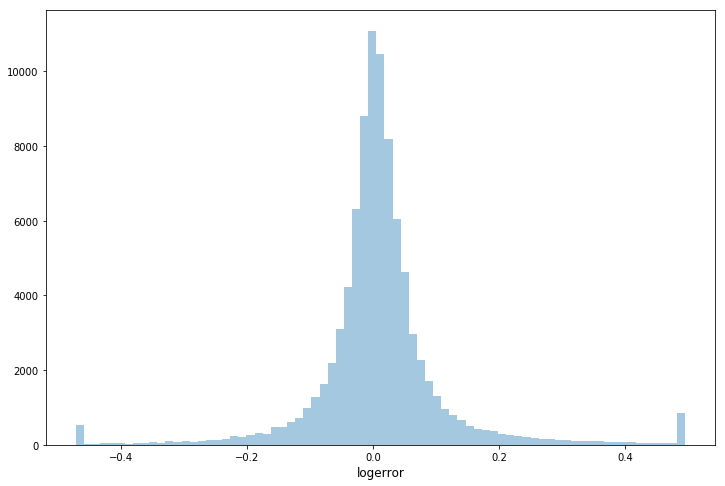

In [26]:
plt.figure(figsize=(12,8))
sns.distplot(train_merge.logerror.values, bins=75, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

'logerror' is normally distributed.


#### Finished SquareFeet 12:

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


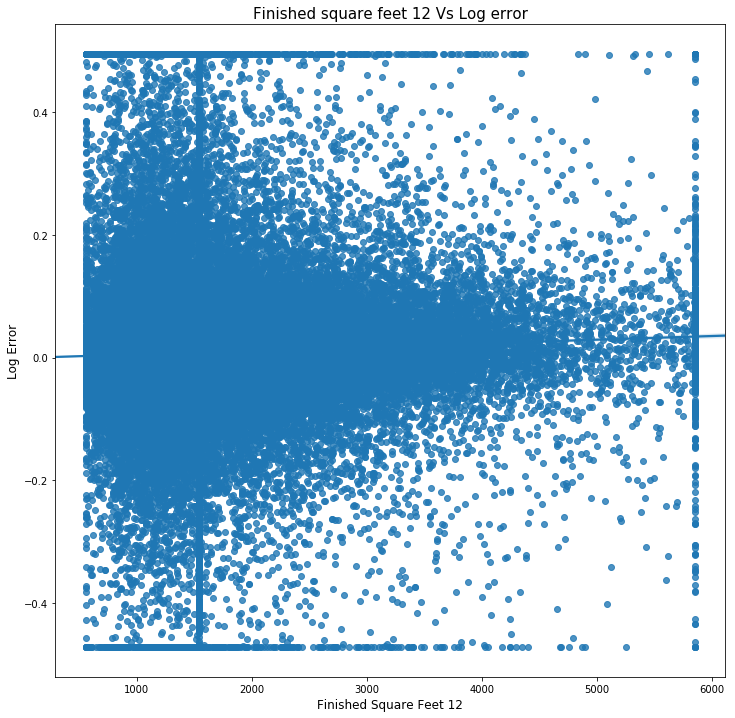

In [27]:
col = "finishedsquarefeet12"
ulimit = np.percentile(train_merge[col].values, 99.5)
llimit = np.percentile(train_merge[col].values, 0.5)
train_merge[col].ix[train_merge[col]>ulimit] = ulimit
train_merge[col].ix[train_merge[col]<llimit] = llimit


plt.figure(figsize=(12,12))
sns.regplot(x="finishedsquarefeet12", y="logerror", data=train_merge)
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Finished Square Feet 12', fontsize=12)
plt.title("Finished square feet 12 Vs Log error", fontsize=15)
plt.show()

Range of logerror narrows down with increase in finishedsquarefeet12 variable

#### calculatedfinishedsquarefeet

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


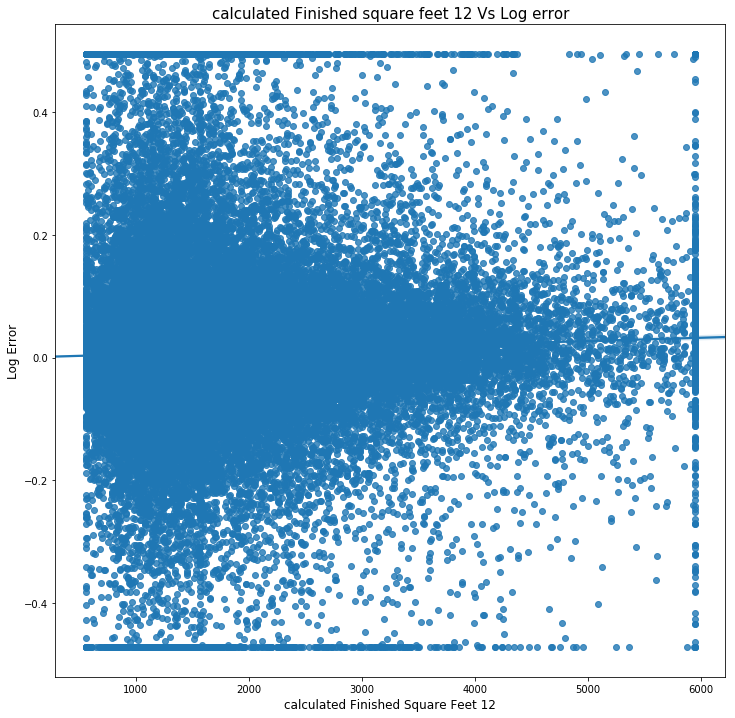

In [28]:
col = "calculatedfinishedsquarefeet"
ulimit = np.percentile(train_merge[col].values, 99.5)
llimit = np.percentile(train_merge[col].values, 0.5)
train_merge[col].ix[train_merge[col]>ulimit] = ulimit
train_merge[col].ix[train_merge[col]<llimit] = llimit


plt.figure(figsize=(12,12))
sns.regplot(x="calculatedfinishedsquarefeet", y="logerror", data=train_merge)
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('calculated Finished Square Feet 12', fontsize=12)
plt.title("calculated Finished square feet 12 Vs Log error", fontsize=15)
plt.show()

Range of logerror narrows down with increase in calculatedfinishedsquare feet variable, which is similar to the above plot.

#### Which is the most common house (bathroom wise) ?

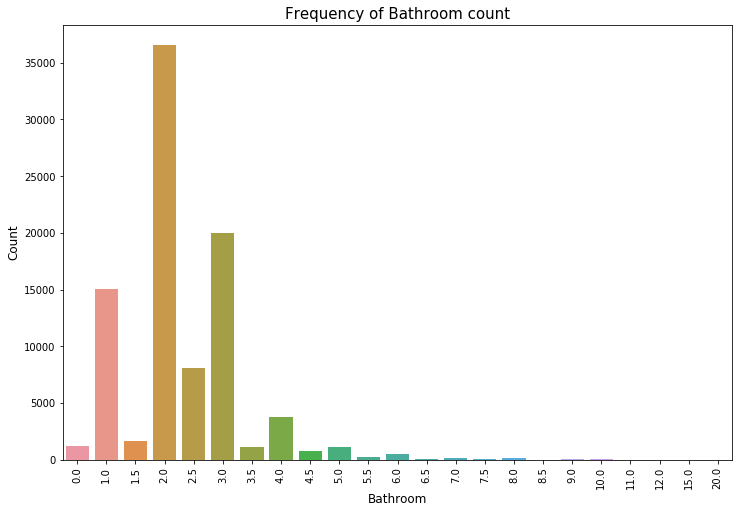

In [29]:
plt.figure(figsize=(12,8))
sns.countplot(x="bathroomcnt", data=train_merge)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Bathroom', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bathroom count", fontsize=15)
plt.show()

Heighest selling houses have bath room more than 2 or 3.

#### Which is the most common house (Bedroom wise) ?

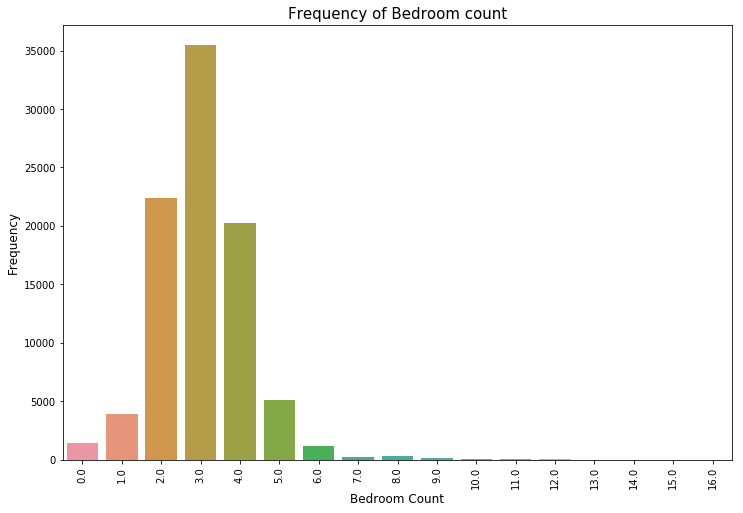

In [30]:
plt.figure(figsize=(12,8))
sns.countplot(x="bedroomcnt", data=train_merge)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Bedroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bedroom count", fontsize=15)
plt.show()

Houses with  3 bedroom’s attract more buyers.

#### Yearbuilt

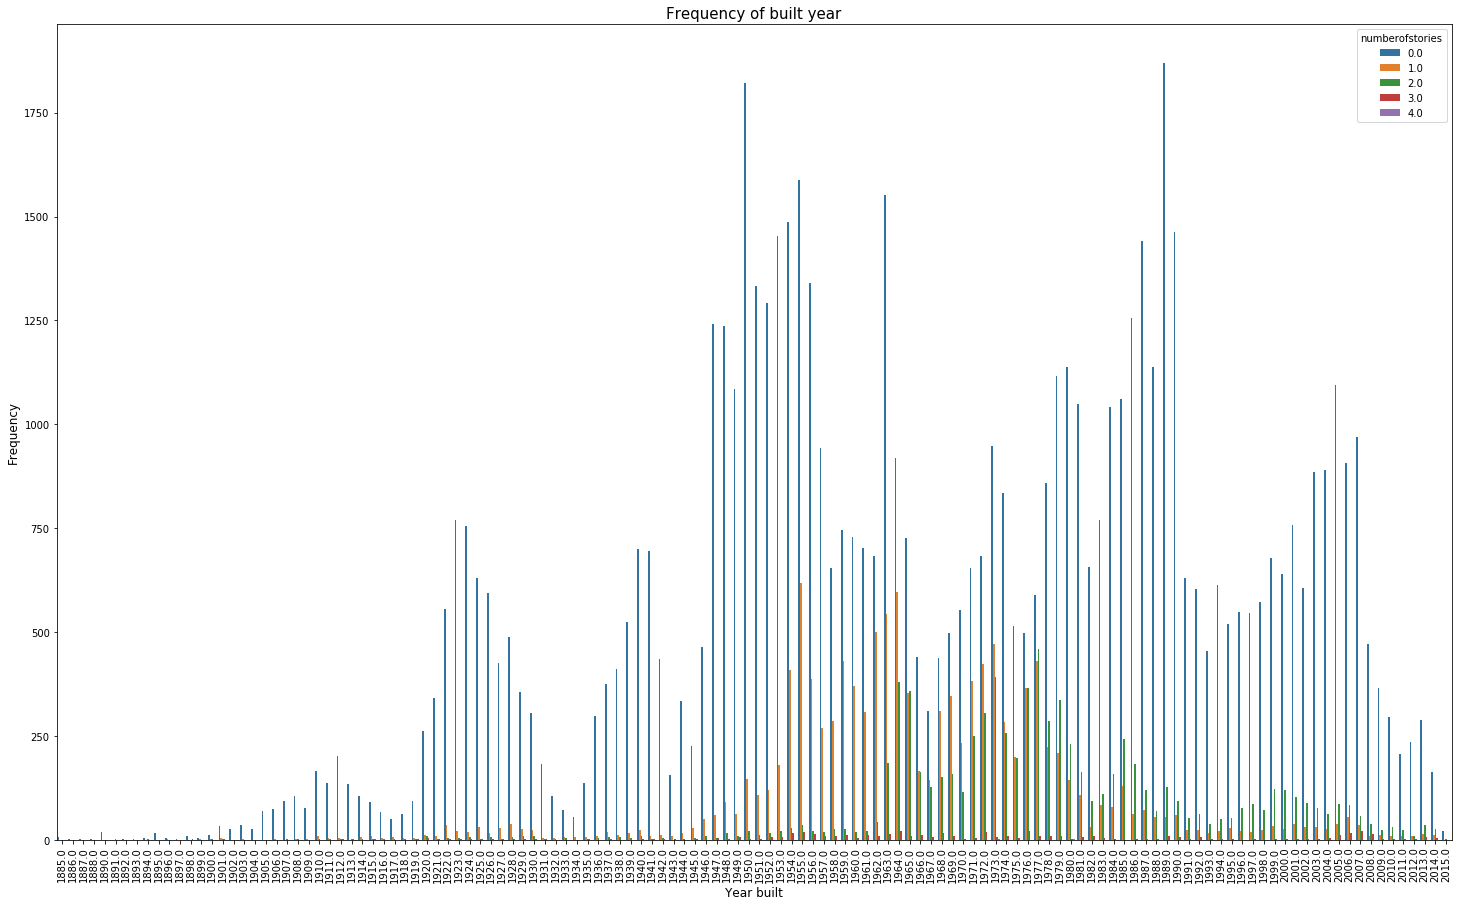

In [32]:
plt.figure(figsize=(25,15))
sns.countplot(x="yearbuilt", data=train_merge,hue='numberofstories')
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Year built', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of built year", fontsize=15)
plt.show()


The count plot is dense between 1946-1990.It looks like there is sudden increase in double storied buildings between 1963-1981. It is quite interesting to notice people started building more of 2 or 3 storey buildings After 1945

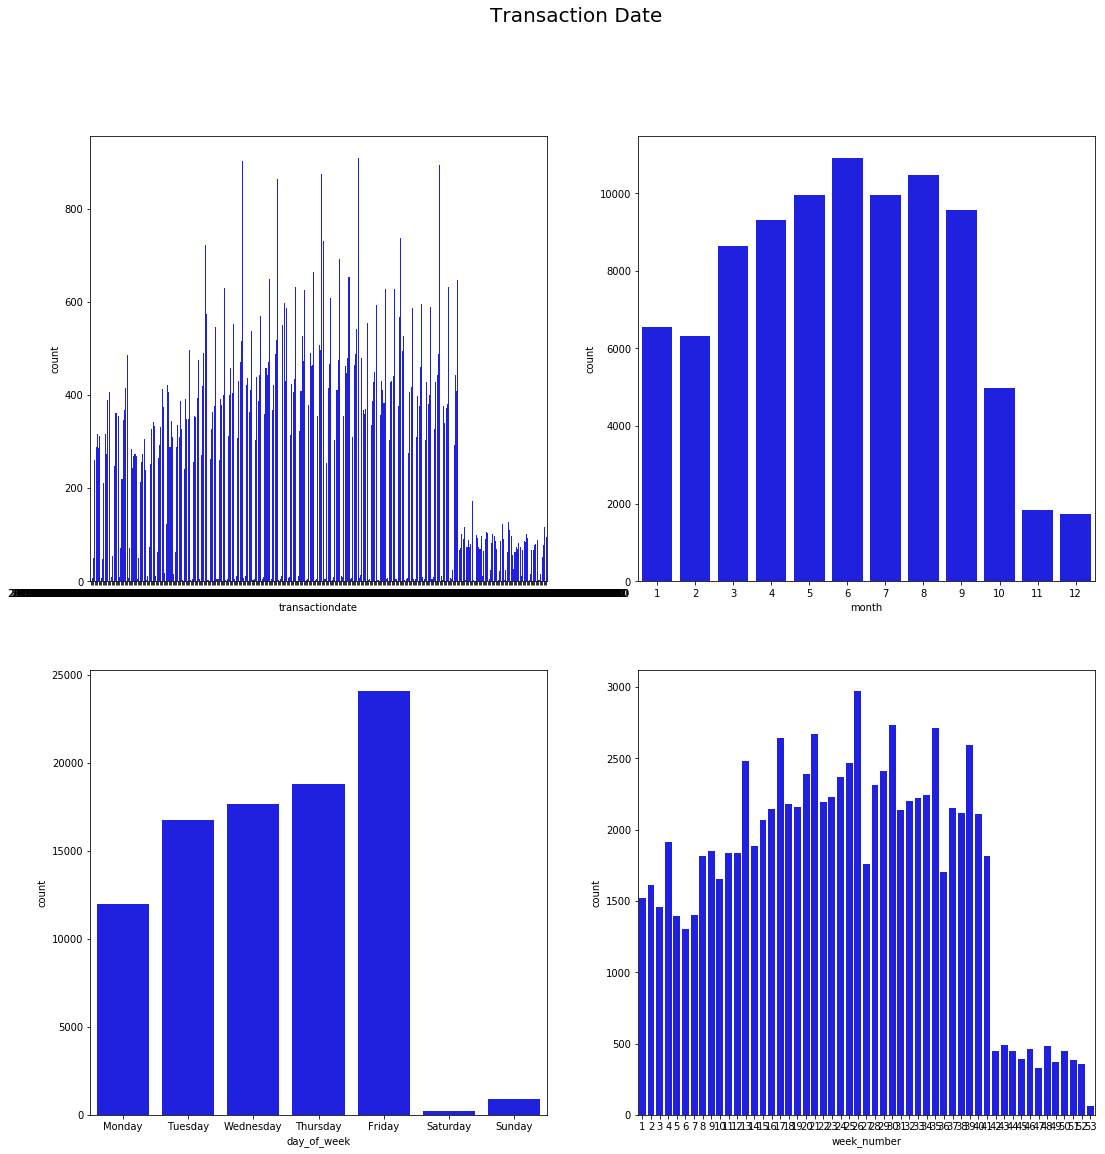

In [33]:
### Scrutinizing transactiondate
fig = plt.figure(figsize=(18, 18));
sns.countplot(x='transactiondate', color='blue', data=train_merge, ax = plt.subplot(221));
sns.countplot(x='month', color='blue', data=train_merge, ax = plt.subplot(222));
sns.countplot(x='day_of_week', color='blue', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                                                      'Friday', 'Saturday', 'Sunday'], 
              data=train_merge, ax = plt.subplot(223));
sns.countplot(x='week_number', color='blue', data=train_merge, ax = plt.subplot(224));
plt.suptitle('Transaction Date', fontsize=20);

Now let us see how the logerror varies with respect to latitude and longitude.

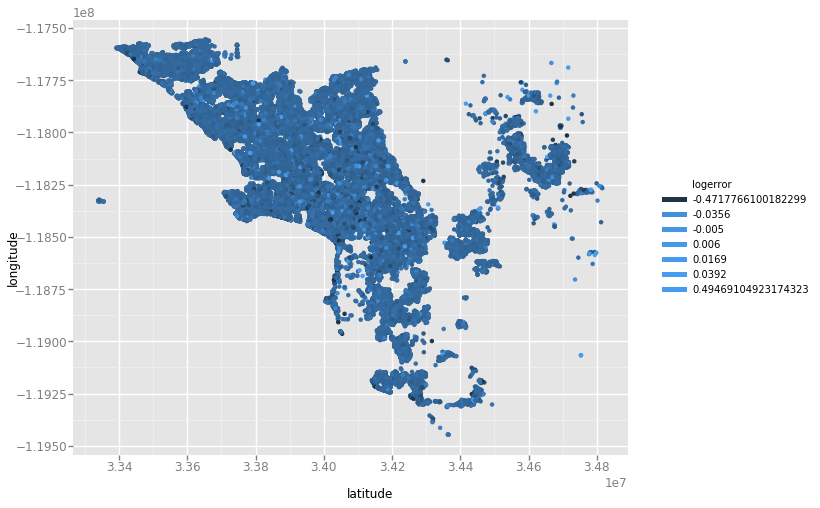

<ggplot: (167602822818)>

In [34]:
ggplot(aes(x='latitude', y='longitude', color='logerror'), data=train_merge) + \
    geom_point() 
 #   scale_color_gradient(low = 'red', high = 'blue')

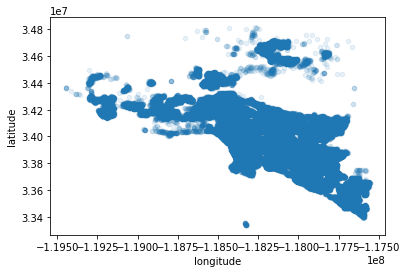

In [35]:
train_merge.plot(kind='scatter', x='longitude', y='latitude',alpha=0.1)

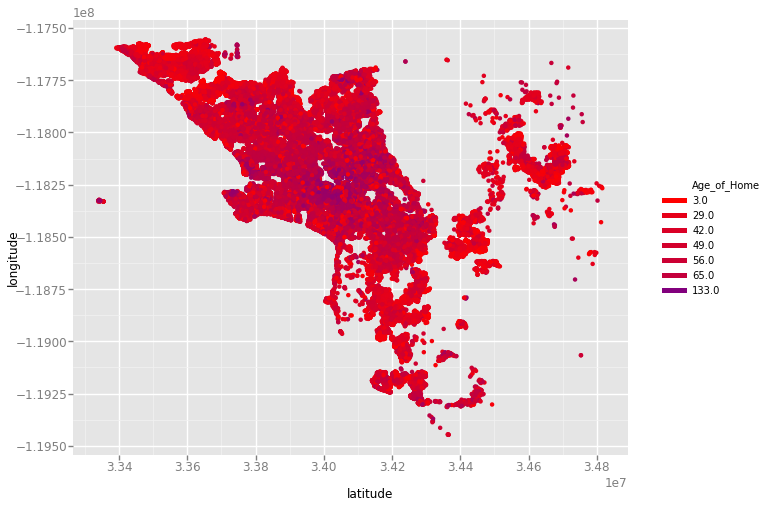

<ggplot: (-9223371869292706735)>

In [36]:
ggplot(aes(x='latitude', y='longitude', color='Age_of_Home'), data=train_merge) + \
    geom_point() + \
    scale_color_gradient(low = 'red', high = 'purple')

#### Final Result:

XGB model produced the lowest logerror among all the models.


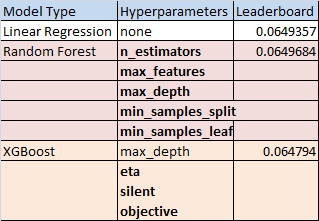